# 5.2 구매 데이터를 분석하여 상품 추천하기

이번 절에서는 구매 데이터 분석에 기반한 온라인 스토어 상품 추천 시뮬레이션 예제를 알아보겠습니다. 예제에서는 피처 엔지니어링, 그리고 행렬 완성 기반 점수 예측 방법을 이용하여 상품 추천 시물레이션을 수행합니다. 분석에 사용할'UK Retail'데이터는 영국의 한 선물 판매 온라인 스토어에서 발생한 거래 데이터로, 주 고객은 선물 도매상입니다.

## Step 1 탐색적 분석: UK Retail 데이터 분석하기
예제에서 사용할 UK Retail 데이터셋은 다음과 같은 피처로 구성되어 있습니다.
- invoiceNO : 거래 고유 번호
- StockCode : 상품 고유 번호
- Description : 상품명 
- Quantiy : 거래 수량
- InvoiceDate : 거래 일시
- UnitPrice : 상품 단가
- CustomerID : 구매자 고유 번호
- Country : 구매 국가<br>

아래의 코드를 통해 데이터를 살펴본 결과, 약 54만 개 정도의 데이터가 존재하며 그 중 14만 개의 데이터는 구매자 정보가 결측값인 것을 알 수 있습니다.

#### 데이터셋 살펴보기

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 영국 온라인 스토어 도매 거래 데이터
df = pd.read_csv("data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = "%m/%d/%Y %H:%M")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


본격적인 탐색적 데이터 분석에 앞서, 데이터에서 예외적인 상황을 필터링하여 이상치를 제거해야 합니다. 가장 먼저 결측 데이터를 제거하겠습니다. 다음 코드와 실행 결과는 ㄴ유저 정보가 없는 13만5천여 개의 데이터, 상품 상세정보가 없는 1,500여 개의 데이터를 제거한 것입니다.

#### 결측 데이터 제거하기

In [2]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [3]:
df = df.dropna()
print(df.shape)

(406829, 8)


다음은 데이터가 일반적이지 않은 경우를 탐색하고 이를 제거하겠습니다. 이번에는 상품 수량 데이터가 이상한 경우를 탐색합니다. 아래의 코드는 상품 수량이 0 이하인 경우 해당 값을 데이터 프레임에서 제거하는 과정입니다. 이러한 경우는 아마도 환불이나 주문 취소를 의미하는 것 같지만 그 의미가 명확하지 않으니 제거합니다. 코드의 실행 결과, 약 9,000여 개의 데이터가 제거되었습니다.

#### 탐색 데이터의 조건 필터링: 상품 수량이 0 이하인 경우

In [4]:
# 상품 수량이 음수인 경우를 제거합니다.
print(df[df['Quantity']<=0].shape[0])
df = df[df['Quantity']>0]

8905


이번에는 상품 가격이 0 이하인 경우를 탐색합니다. 이 역시 일반적인 상황이라고 할 수 없는 상황이기 때문에 조건에 해당하는 데이터를 제거합니다. 아래 코드의 실행 결과, 총 40개의 데이터가 제거되었습니다.

#### 탐색 데이터의 조건 필터링: 상품가격이 0 이하인 경우

In [5]:
# 상품 가격이 0 이하인 경우를 제거합니다.
print(df[df['UnitPrice']<=0].shape[0])
df = df[df['UnitPrice']>0]

40


마지막으로 상품 코드가 이상한 경우를 탐색하고 제거합니다. 데이터 내의 StockCode를 관찰해 보면 대부분의 상품 코드가 번호로 이루어져 있는 것을 알 수 있습니다. 따라서 상품 코드가 번호가 아닌 경우는 예외적인 상황일 것입니다. 아래 실행 결과는 이러한 데이터를 살펴본 것입니다.

#### 탐색 데이터의 조건 필터링: 상품 코드가 일반적이지 않은 경우

In [6]:
# 상품 코드가 일반적이지 않은 경우를 탐색합니다.
df['ContainDigit'] = df['StockCode'].apply(lambda x: any(c.isdigit() for c in x))
print(df[df['ContainDigit'] == False].shape[0])
df[df['ContainDigit'] == False].head()

1414


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ContainDigit
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France,False
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany,False
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,False
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,False


그리고 아래의 코드를 실행하여 일반적이지 않은 상품 코드를 가진 데이터를 제거합니다.

In [7]:
# 상품 코드가 일반적이지 않은 경우를 제거합니다.
df = df[df['ContainDigit'] == True]

이제 본격적으로 탐색적 분석을 수행할 차례입니다. 이번 예제에서는 어떤 방향성을 가지고 탐색적 분석을 진행해야 할까요? 분석 방향을 잘 설정하기 위해 지금부터 우리는 특정 시점에 도매상들에게 선물을 판매하는 온라인 스토어의 운영자 입장이 되어보겠습니다. 그리고 우리의 고민은 다음과 같습니다.
- '연말에 온라인 스토어에 방문하는 유저들에게 어떤 상품을 추천해줄 수 있을까?'<br>

연말에 방문한 유저들에게 상품을 추천해준다는 것은 유저-상품 간의 구매 확률을 예측해보는 시뮬레이션이라고 할 수 있습니다. 이러한 예측 시뮬레이션은 아래와 같은 분석 과정이 필요합니다.
- (1) 연말 이전까지의 데이터를 유저-상품 간의 구매를 예측하는 모델의 학습 데이터셋으로 사용합니다.
- (2) 실제 연말에 구매한 유저-상품 간의 정보를 테스트 데이터셋으로 사용합니다.
- (3) 모델이 예측한 유저-상품 간의 구매 정보와 실제 구매 정보(테스트 데이터셋)을 비교하여 추천이 잘 되었는지 평가합니다.<br>

이제 우리는 위와 같은 예측 분석을 수행하기 위한 탐색적 데이터 분석(EDA)이 필요합니다. 우리에게 필요한 탐색은 특정 시간을 기준으로 데이터를 나누고, 데이터에서 구매 패턴과 같은 특징을 발견하는 것입니다. 따라서 가장 먼저 할 것은 일자별 주문의 탐색입니다.<br>
다음의 실행 결과는 가장 오래된 데이터와 가장 최신의 데이터를 출력한 것이며 이를 통해 데이터가 2010년 12월부터 2011년 12월까지 존재하는 것을 알 수 있습니다.

#### 데이터의 기간 탐색하기

In [8]:
# 거래 데이터에서 가장 오래된 데이터와 가장 최신의 데이터를 탐색합니다.
df['date'] = df['InvoiceDate'].dt.date
print(df['date'].min())
print(df['date'].max())

2010-12-01
2011-12-09


다음으로 일자별 거래량을 탐색합니다. 아래의 실행 결과는 일자별 거래량을 시계열 그래프로 출력한 것입니다. 코드에서는 일자를 나타내는 date 피처를 그룹의 기준으로 하여, 일자별 Quantity의 합계를 계산하였습니다. 그래프를 살펴보면 대체적으로 연말에 가까워질수록 거래량이 증가하는 것을 알 수 있으며 10~11월 정도를 기점으로 증가폭이 조금씩 커지고 있다는 것을 알 수 있습니다.

#### 일자별 거래 수량 탐색하기

<AxesSubplot:xlabel='date'>

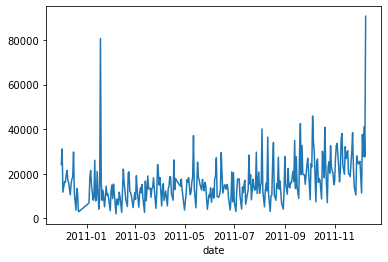

In [9]:
# 일자별 총 거래 수량을 탐색합니다.
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()

다음 일자별 거래 횟수를 탐색합니다. 아래의 코드도 마찬가지로 date 피처를 그룹의 기준으로 하였고, nunique() 함수를 InvoiceNO 피처에 적용하여 일자별로 발생한 거래 횟수를 계산합니다. 코드의 실행 결과는 일자별 거래량을 시계열 그래프로 나타낸 것입니다. 거래 횟수는 연말에 가까워질수록 거래 수량보다 조금 더 가파르게 상승하고 있습니다.

#### 일자별 거래 횟수 탐색하기

<AxesSubplot:xlabel='date'>

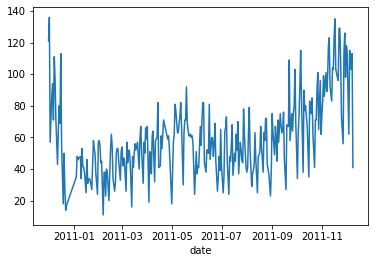

In [10]:
# 일자별 총 거래 횟수를 탐색합니다.
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

마지막으로 일자별 거래 상품 개수를 탐색합니다. 아래 코드의 실행 결과, 지금까지의 그래프 중 가장 가파른 상승세를 나타내고 잇습니다. 지금까지의 내용을 종합해보면 연말이 시작되는 약 10~11월 정도부터 연중보다 더 많이 그리고 더 자주 구매가 일어난다는 것을 알 수 있습니다.

#### 일자별 거래 상품 개수 탐색하기

<AxesSubplot:xlabel='date'>

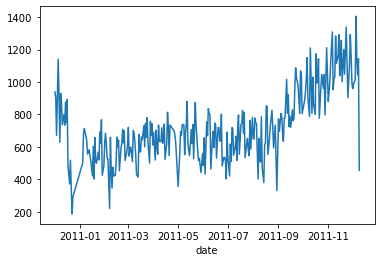

In [11]:
# 일자별 거래되 상품의 unique한 개수, 즉 상품 거래 다양성을 탐색합니다.
date_unique_item_series = df.groupby('date')['StockCode'].nunique()
date_unique_item_series.plot()

이번에는 전체 데이터에서 등장한 유저들의 구매 패턴을 탐색해봅시다. 아래의 실행 결과는 전체 데이터에 등장한 유저의 수를 출력하는 코드를 실행한 것입니다. 이를 통해 총 4,334명의 유저가 데이터에 존재하는 것을 알 수 있습니다.

#### 전체 유저의 수 탐색하기

In [12]:
# 총 유저의 수를 계산하여 출력합니다.
print(len(df['CustomerID'].unique()))

4334


4,334명의 유저를 대상으로 각각의 거래 횟수를 탐색합니다. 다음 코드는 CustomerID를 그룹으로 하여 unique한 InvoiceNo를 계산한 것이고, 이결과에 describe() 함수를 적용하여 유저별 거래 횟수에 대한 요약 통꼐 정보를 출력하였습니다. 출력 결과를 살펴보면 유저들은 평균적으로 약 4회 정도의 구매가 있었다는 것을 알 수 있고, 대부분의 유저는 1~5회 정도의 구매 횟수를 보인다는 것을 알 수 있습니다.

#### 유저별 거래 횟수 탐색하기

In [13]:
# 유저별 거래 횟수를 탐색합니다.
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

그리고 이를 상자 그림으로 살펴본 결과는 아래와 같습니다.

#### 유저별 거래 횟수 시각화하기

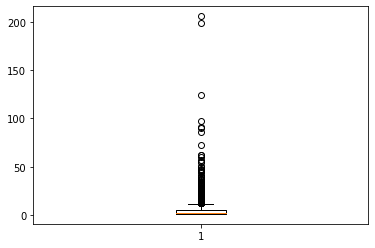

In [14]:
# 상자 그림 시각화로 살펴봅니다.
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

다음으로 유저별로 구매한 상품은 몇 종류나 되는지를 탐색해봅시다. 아래의 코드는 CustomerID그룹에 unique한 StockCode를 계산하여 describe() 함수를 적용한 것입니다. 그리고 이를 통해 유저들은 평균적으로 약 60여 개 종류의 상품을 구매했다는 것을 알 수 있습니다. 하지만 데이터의 편차는 매우 높은 수치를 보이고 있습니다.

#### 유저별 상품 구매 종류 탐색하기

In [15]:
# 유저별 아이템 구매 종류 개수를 탐색합니다.
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

마찬가지로 이 결과를 상자 그림으로 살펴보았습니다. 거래 횟수보다는 조금 더 다양하게 데이터가 분포되어 있는 것을 알 수 있습니다.

#### 유저별 상품 구매 종류 시각화하기

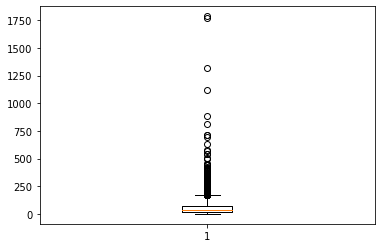

In [16]:
# 상자 그림 시각화로 살펴봅니다.
plt.boxplot(customer_unique_item_series.values)
plt.show()

이제 특정 시점을 기준으로 데이터를 분리하여 구매의 패턴을 분석해봅시다. 중점적으로 살펴볼 내용은 두 데이터에서 동일하게 등장하는 유저-상품 단위의 구매 데이터, 즉 재구매 여부입니다. 또한 신규 구매가 얼마나 일어났는지 역시 중요하게 살펴볼 내용입니다.<br>
먼저 11월 1일을 연말의 기준으로 삼아 두 개의 데이터로 분리합니다. 이 두 데이터는 추후에 예측분석에 사용할 학습 데이터셋, 그리고 테스트용 데이터셋을 의미하며 각각 314,902개, 81,568개의 데이터로 분리되었습니다.

#### 일자를 기준으로 데이터 분리하기

In [17]:
import datetime

# 2011년 11월을 기준으로 하여 기준 이전과 이후로 데이터를 분리합니다.
df_year_round = df[df['date'] < datetime.date(2011, 11, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)]
print(df_year_round.shape)
print(df_year_end.shape)

(314902, 10)
(81568, 10)


분리된 데이터에서 재구매, 신규 구매 등이 어떻게 일어났는지를 분석해봅시다. 먼저 해야 하는 것은 11월 이전 데이터셋에서 유저별로 구매했던 상품의 리스트를 추출하는 것입니다. 아래의 코드는 CustomerID를 그룹으로 하여 StockCode 피처에 apply(set) 함수를 적용한 것으로 이를 통해 유저별 StockCode의 집합(set)을 추출할 수 있습니다.

#### 11월 이전 유저별로 구매했던 상품의 집합 추출하기

In [18]:
# 11월 이전 데이터에서 구매했던 상품의 set을 추출합니다.
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346                                              {23166}
12347    {21791, 84969, 22945, 22196, 23173, 23480, 225...
12348    {23076, 22616, 84991, 22952, 21983, 21967, 219...
12350    {22412, 22551, 84086C, 21832, 22620, 20652, 21...
12352    {21232, 22780, 22779, 22413, 21756, 22624, 232...
                               ...                        
18280    {22084, 82484, 22611, 22495, 22727, 22499, 223...
18281    {23209, 23008, 22028, 22716, 23007, 22467, 22037}
18282    {21270, 22424, 21108, 23187, 22089, 23295, 21109}
18283    {21791, 21181, 23373, 85152, 22553, 22554, 221...
18287    {21232, 21481, 23267, 72351B, 23076, 22306, 22...
Name: StockCode, Length: 3970, dtype: object


다음 유저-상품 단위의 딕셔너리(사전)를 정의합니다. 이 딕셔너리는 유저가 상품을 11월 이전에 구매했는지 혹은 11월 이후에 구매했는지를 기록하기 위한 것입니다. 아래의 코드를 실행하면 유저가 11월 이전에 구매한 상품은 딕셔너리에'old'라고 표기됩니다.

#### 유저별 구매 사전 구축하기

In [19]:
# 11월 이전에 구매했는지 혹은 이후에 구매했는지를 유저별로 기록하기 위한 사전을 정의합니다.
customer_item_dict = {}

# 11월 이전에 구매한 상품은 'old'라고 표기합니다.
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock_code in stocks:
        customer_item_dict[customer_id][stock_code] = 'old'
        
print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'21791': 'old', '84969': 'old', '22945': 'old', '22196': 'old'...


이는 실행 결과를 보면 쉽게 이해할 수 있습니다. 12346번 유저는 23166 상품을 구매했었고, 12347번 유저는 22697, 22371, 85167B.... 상품을 구매했었다는 사실을 나타냅니다.

위에서와 동일한 방식으로 11월 이후 데이터에서 유저별로 구매한 상품의 집합을 추출합니다.

#### 11월 이후 유저별로 구매했던 상품의 집합 추출하기

In [20]:
# 11월 이후 데이터에서 구매하는 상품의 집합을 추출합니다.
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_end_set)

CustomerID
12347    {21265, 21064, 21731, 23552, 23271, 23508, 234...
12349    {23439, 21232, 23460, 22601, 22553, 23112, 217...
12352    {23367, 21669, 22178, 23089, 22624, 22978, 230...
12356                                       {22423, 21843}
12357    {22819, 37446, 22306, 23355, 21411, 22067, 221...
                               ...                        
18272    {22074, 84380, 22993, 23240, 72799C, 22969, 23...
18273                                             {79302M}
18274    {21974, 21231, 22851, 21108, 22423, 22989, 232...
18282                  {23174, 22818, 22699, 23175, 22423}
18283    {21791, 21181, 23582, 22553, 22554, 23379, 359...
Name: StockCode, Length: 1904, dtype: object


11월 이후에 구매한 유저별 상품의 집합을 이용하여 앞서 정의했던 유저-상품 구매 상태 딕셔너리를 업데이트합니다. 다음 코드는 기존에 구매하여'old'라고 표기되어 있던 것은'both'로 업데이트하고, 사전에 없던 유저-상품이 경우에는'new'라고 표기하는 과정입니다. 딕셔너리의 업데이트가 완료되면 11월 이전에만 구매한 유저-상품은'old', 이후에만 구매한 상품은'new', 모두 구매한 상품은'both'로 표기된 딕셔너리 구축이 완료됩니다. 이제 이를 통해 유저별 재구매, 신규 구매 등의 패턴을 분석할 수 있습니다.

#### 유저별 구매 사전 업데이트하기

In [21]:
# 11월 이전에만 구매한 상품은 'old', 이후에만 구매한 상품은 'new', 모두 구매한 상품은 'both'라고 표기합니다.
for customer_id, stocks in customer_item_end_set.items():
    # 11월 이전 구매기록이 있는 유저인지를 체크합니다.
    if customer_id in customer_item_dict:
        for stock_code in stocks:
            # 구매한 적 있는 상품인지를 체크한 뒤, 상태를 표기합니다.
            if stock_code in customer_item_dict[customer_id]            :
                customer_item_dict[customer_id][stock_code] = 'both'
            else:
                customer_item_dict[customer_id][stock_code] = 'new'
    # 11월 이전 구매기록이 없는 유저라면 모두 'new'로 표기합니다.
    else:
        customer_item_dict[customer_id] = {}
        for stock_code in stocks:
            customer_item_dict[customer_id][stock_code] = 'new'
            
print(str(customer_item_dict)[:100] +"...")

{'12346': {'23166': 'old'}, '12347': {'21791': 'old', '84969': 'old', '22945': 'old', '22196': 'old'...


구축 완료된 딕셔너리를 조금 더 편하게 분석하기 위해 데이터 프레임의 형태로 다시 정리합니다. 다음 코드는 미리 비어있는 데이터 프레임을 생성해놓고 딕셔너리를 반복문으로 들여다보며 비어있는 프레임에 데이터를 추가합니다.

#### 구매 사전을 데이터 프레임으로 정리하기

In [23]:
# 'old','new','both'를 유저별로 탐색하여 데이터 프레임을 생성합니다.
columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns=columns)

# 데이터 프레임을 생성하는 과정입니다.
for customer_id in customer_item_dict:
    old = 0
    new = 0
    both = 0
    
    # 상품 상태(old, new, both)를 체크하여 데이터 프레임에 append할 수 있는 형태로 처리합니다.
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'old':
            old += 1
        elif status == 'new':
            new += 1
        else:
            both += 1
    # df_order_info에 데이터를 append합니다.
    row = [customer_id, old, new, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)
        
df_order_info.head()

,CustomerID,old,new,both
0,12346,1,0,0
1,12347,92,3,8
2,12348,21,0,0
3,12350,16,0,0
4,12352,43,12,2


이렇게 정리된 데이터 프레임을 활용하여 재구매와 신규 구매가 어떤 패턴으로 발생하였는지 탐색해봅시다. 다음 코드는 3가지를 출력한 것으로 첫 번째는 데이터 프레임의 열 개수, 즉 전체 유저수를 출력한 것입니다. 그리고 두 번째 'old'가 1개 이상이면서 동시에'new'가 1개 이상인 유저가 몇 명인지를 출력한 것입니다. 이를 통해 11월 이후에 기존에 구매한 적 없던 신규 상품을 구매한 유저가 약 3분의 1 가량 된다는 것을 알 수 있습니다. 마지막 세 번째는'both'가 1 이상인 유저 수를 출력한 것으로 이는 재구매한 상품이 있는 유저 수를 의미합니다. 즉 3분의 1정도는 11월 이전에 구매했던 상품을 11월 이후에 다시 구매한다는 것을 의미합니다.

#### 재구매, 신규 구매 유저 분석하기

In [ ]:
# 데이터 프레임에서 전체 유저 수를 출력합니다.
print(df_order_info.shape[0])
# 데이터 프레임에서 old가 1 이상이면서, new가 1 이상인 유저 수를 출력합니다.
# 11월 이후에 기존에 구매한 적 없는 새로운 상품을 구매한 유저를 의미합니다.
